# Upstream Statistical Analyses of h5ad files

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np

adata = sc.read_h5ad('/home/glennrdx/Documents/Research_Project/processed_h5ad/1.2 crypt_enriched_main.h5ad')
adata_eec = sc.read_h5ad('/home/glennrdx/Documents/Research_Project/processed_h5ad/1.3 crypt_enriched_eec.h5ad')

## Functions For Reproducibility

In [12]:
def plot_cell_type_proportions(adata, annotation, exclude_clusters=['Paneth', 'Paneth Progenitor'], text_size=10):
    """
    Create a bar plot of cell type proportions across diets with error bars and individual sample points.
    
    Parameters:
    adata (AnnData): The AnnData object containing the single-cell data.
    annotation (str): The column name in adata.obs for cell type annotation.
    exclude_clusters (list): List of cluster names to exclude from the plot.
    text_size (int): Font size for text elements in the plot. Default is 10.
    
    Returns:
    None: Displays the plot.
    """
    # Filter out excluded clusters
    adata_filtered = adata[~adata.obs[annotation].isin(exclude_clusters)].copy()
    
    # Assume 'Sample' column exists and contains diet information
    sample_column = 'Sample'
    
    # Extract diet information from the Sample column
    adata_filtered.obs['Diet'] = adata_filtered.obs[sample_column].str.split('_').str[0]
    
    # Group by cell type and sample, then count occurrences
    table = adata_filtered.obs.groupby([annotation, sample_column], observed=False).size().unstack(fill_value=0)
    
    # Calculate the proportions
    proportions = table.div(table.sum(axis=0), axis=1)
    
    # Map samples to diets
    diet_mapping = {sample: sample.split('_')[0] for sample in proportions.columns}
    proportions.columns = proportions.columns.map(diet_mapping)
    
    # Calculate mean proportions for each diet
    mean_proportions = proportions.T.groupby(proportions.columns).mean().T
    
    # Calculate the SEM for each diet and cell type
    sem_proportions = proportions.T.groupby(proportions.columns).sem().T
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35
    x = np.arange(len(mean_proportions.index))
    
    # Define colors for each diet (as in the original code)
    colors = {'CD': 'grey', 'HFD': 'red'}
    
    # Plot bars with error bars (SEM) and scatter points for each diet
    for i, diet in enumerate(mean_proportions.columns):
        ax.bar(x + i * bar_width, mean_proportions[diet], width=bar_width, color=colors[diet],
               yerr=sem_proportions[diet], capsize=5, label=diet)
        
        # Plot individual sample points for each diet
        for j, cell_type in enumerate(mean_proportions.index):
            # Extract the proportions for this specific cell type and diet
            sample_values = proportions.loc[cell_type, proportions.columns == diet]
            ax.scatter(np.full(sample_values.shape, x[j] + i * bar_width), sample_values, color='black', s=10, zorder=3)
    
    # Adding labels and title
    ax.set_xlabel('', fontsize=text_size)
    ax.set_ylabel('Proportion of Cells', fontsize=text_size)
    ax.set_title(f'Proportion of Each Cell Type per Diet', fontsize=text_size + 2)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(mean_proportions.index, rotation=30, ha='right', fontsize=text_size - 2)
    ax.tick_params(axis='y', labelsize=text_size - 2)
    ax.legend(title='Diet', fontsize=text_size - 2, title_fontsize=text_size)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_cell_type_proportions(adata, 'leiden15', text_size=12)

In [238]:
def plot_combined_gene_heatmaps_umap(adata, marker_dict, figsize=(15, 10), fontsize = 10, point = 20):
    """
    Plot combined heatmap UMAPs for multiple cell types in a 2x3 grid with a single color bar.
    Each cell type is normalized independently.
    """
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.1])

    for idx, (cell_type, genes) in enumerate(marker_dict.items()):
        ax = fig.add_subplot(gs[idx // 3, idx % 3])
        
        adata_subset = adata[:, genes].copy()
        
        # Calculate min and max average expression before scaling
        min_avg_exp = np.min(adata_subset.X.mean(axis=1))
        max_avg_exp = np.max(adata_subset.X.mean(axis=1))
        
        sc.pp.scale(adata_subset)
        adata_subset.obs['combined_expression'] = adata_subset.X.mean(axis=1)
        
        # Normalize combined expression to 0-100 range for this cell type
        min_exp = adata_subset.obs['combined_expression'].min()
        max_exp = adata_subset.obs['combined_expression'].max()
        adata_subset.obs['combined_expression_normalized'] = (adata_subset.obs['combined_expression'] - min_exp) / (max_exp - min_exp) * 100

        sc.pl.umap(
            adata_subset,
            color='combined_expression_normalized',
            title='',
            frameon=False,
            ax=ax,
            size=point,
            color_map='viridis',
            vmin=0,
            vmax=100,
            show=False,
            colorbar_loc=None  # This removes the individual color bars
        )
        ax.set_facecolor('black')
        ax.set_title(f"{cell_type}: \n {', '.join(genes)}", fontsize=fontsize, pad=5)
        ax.annotate(f"min avg exp: {min_avg_exp:.2f}\nmax avg exp: {max_avg_exp:.2f}",
                    xy=(0.05, 0.02), xycoords='axes fraction',
                    ha='left', va='bottom', fontsize=fontsize)

    # Add a single color bar for the entire figure
    cbar_ax = fig.add_subplot(gs[:, -1])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(0, 100))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)  # Changed cbar_axis to cbar_ax
    cbar.set_label('Normalised Expression', rotation=270, labelpad=15, fontsize=fontsize)

    plt.tight_layout()
    plt.show()

# Usage example:
# plot_combined_gene_heatmaps_umap(adata, marker_dict)

In [173]:
def create_stacked_barplot(adata, annotation):
    # Filter out 'NA' values from the annotation
    filtered_adata = adata[adata.obs[annotation] != 'NA']

    # Calculate the proportions and counts of each cell type within each condition
    cell_type_counts = filtered_adata.obs.groupby(['Diet', annotation], observed=True).size().unstack(fill_value=0)
    cell_type_proportions = cell_type_counts.div(cell_type_counts.sum(axis=1), axis=0)

    # Sample size per condition
    sample_sizes = cell_type_counts.sum(axis=1)

    # Extract the predefined colors from the AnnData object
    cell_type_colors = adata.uns[f'{annotation}_colors']

    # Create a color map dictionary
    unique_cell_types = cell_type_counts.columns
    color_map = dict(zip(unique_cell_types, cell_type_colors))

    # Ensure the colors are applied in the same order as the cell types
    cell_type_colors = [color_map[cell_type] for cell_type in unique_cell_types]

    # Plotting the stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot each cell type as a stack with predefined colors
    cell_type_proportions.plot(kind='bar', stacked=True, ax=ax, color=cell_type_colors)

    # Add labels and title with increased font size
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_xlabel('Diet', fontsize=14)
    ax.set_title(f'Proportion of {annotation} Cell Types Across Diets', fontsize=16)

    # Annotate sample sizes above each bar
    for i, (cond, size) in enumerate(sample_sizes.items()):
        ax.text(i, 1.02, f'N={size}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Annotate percentages within each cell type on the bar segments
    for i, (cond, row) in enumerate(cell_type_counts.iterrows()):
        cum_sum = 0
        for cell_type, count in row.items():
            proportion = cell_type_proportions.loc[cond, cell_type]
            if proportion > 0:
                percentage = proportion * 100
                ax.text(i, cum_sum + proportion / 2, f'{count} ({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='white', weight='bold')
            cum_sum += proportion

    # Rotate x-axis labels for better readability and increase font size
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Display the plot
    plt.show()

# Example usage:
# create_stacked_barplot(adata_eec, 'EEC_final')

In [174]:
# Marker Gene Dictionary
marker_dict = {'ISC': ['Lgr5', 'Olfm4', 'Axin2', 'Ascl2', 'Slc12a2'],
               'Enterocyte': ['Fabp1', 'Alpi', 'Apoa1', 'Apoa4', 'Lct'],
               'Goblet': ['Muc2', 'Tff3', 'Agr2', 'Spdef', 'Klf4', 'Ccl9', 'Manf'],
            #    'Goblet progenitor': ['Spdef', 'Atoh1'],
               'Paneth': ['Lyz1', 'Mmp7', 'Defa17', 'Defa22', 'Ang4'],
               'EEC': ['Neurod1', 'Neurod2', 'Insm1', 'Chga', 'Chgb'],
            #    'EE progenitor': ['Sox4', 'Neurog3', 'Foxa2', 'Foxa3', 'Marcksl1'],
               'Tuft': ['Dclk1', 'Trpm5', 'Gfi1b', 'Il25'],
            #    'Lymphocyte': ['Coro1a', 'Cd52', 'Cd37']
               }

## UMAP Plots

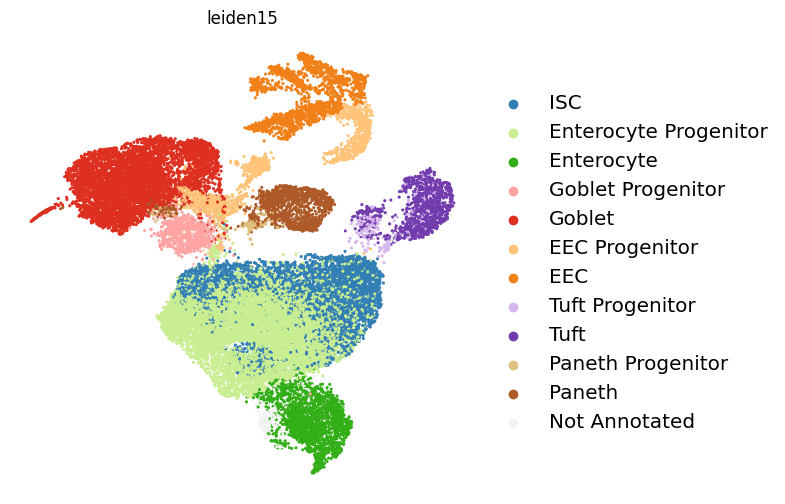

In [179]:
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["leiden15"],
    frameon=False,
    size=20,
    legend_fontsize = 'x-large',
    ax=ax
)

# Show the plot
plt.show()

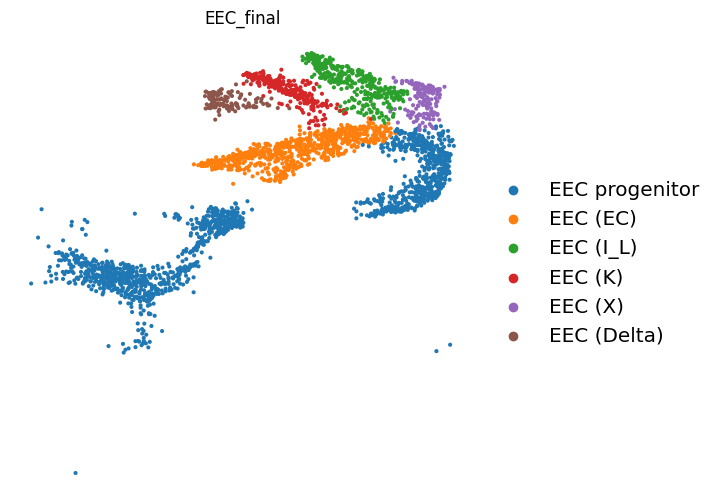

In [180]:
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata_eec,
    color=["EEC_final"],
    frameon=False,
    size=35,
    legend_fontsize = 'x-large',
    ax=ax
)

# Show the plot
plt.show()

## Cell-Type Proportion Plots

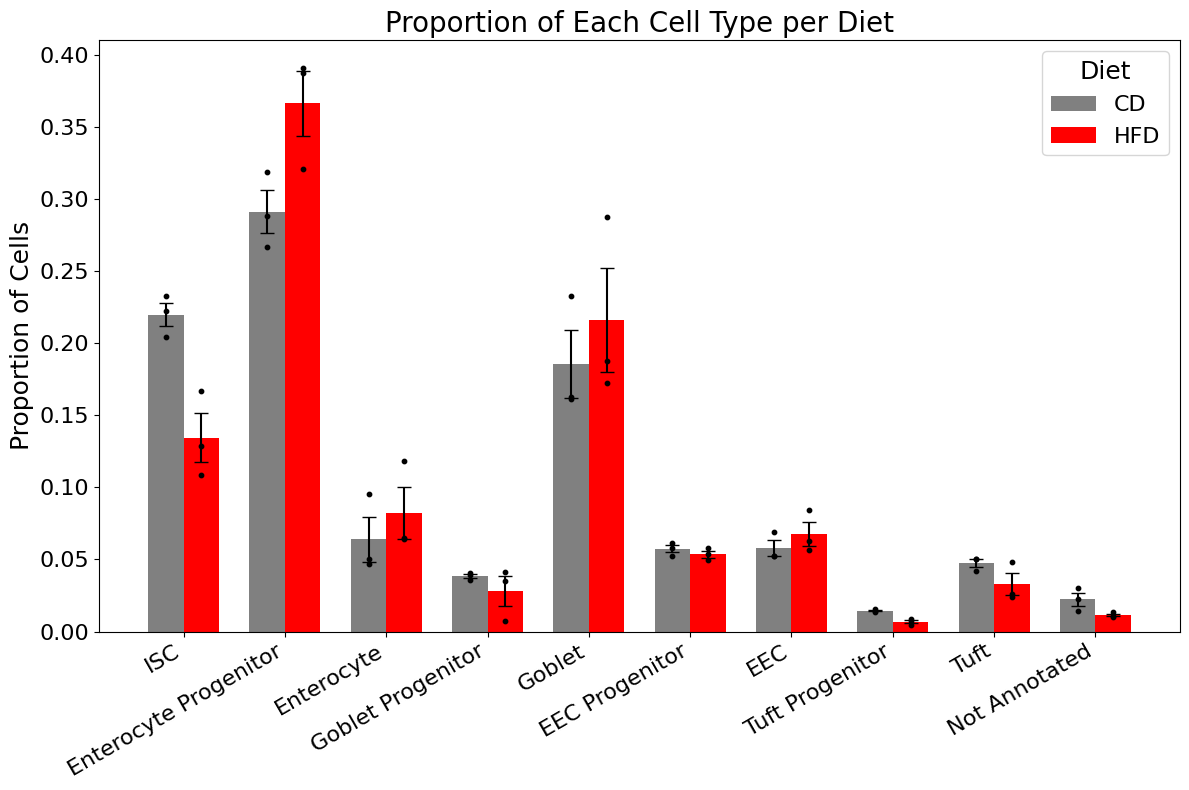

In [13]:
plot_cell_type_proportions(adata, annotation = 'leiden15', text_size = 18)

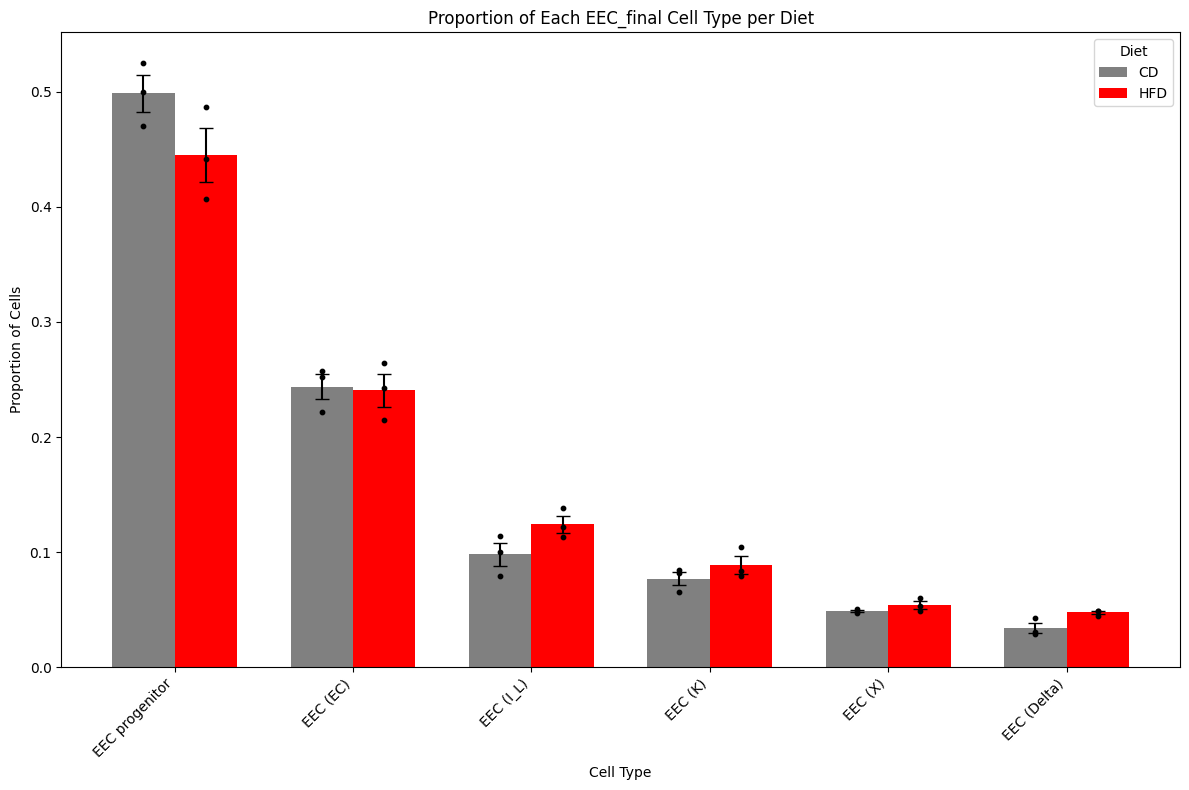

In [157]:
plot_cell_type_proportions(adata_eec, annotation = 'EEC_final')

## Feature Plots

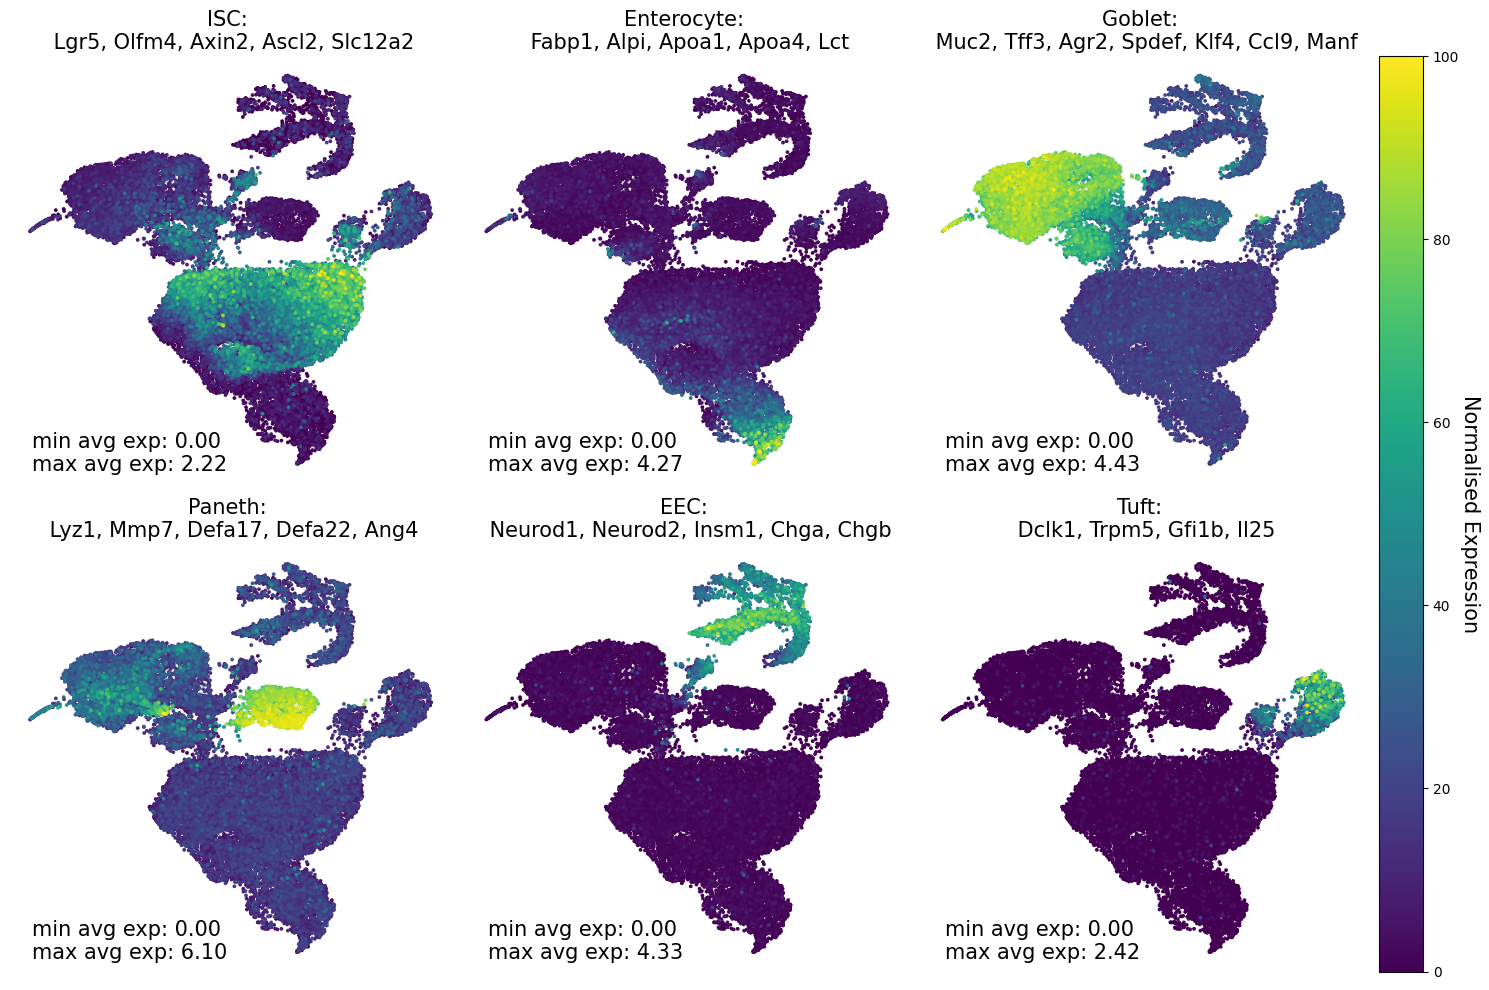

In [241]:
plot_combined_gene_heatmaps_umap(adata, marker_dict, fontsize = 15, point = 30)

## Marker Gene Heatmap

In [213]:
# Subset CD cells from adata
adata_cd_raw = adata[adata.obs['Diet'] == 'CD'].copy()
adata_hfd_raw = adata[adata.obs['Diet'] == 'HFHSD'].copy()

In [214]:
# Remove cell cycle genes
cell_cycle_genes = [x.strip() for x in open('/home/glennrdx/Documents/Research_Project/scRNAseq-MSc-Analysis/3. upstream_analysis/crypt/Misc./preprocessing_remove_cellcycle_effect/GO0007049.txt')]

In [215]:
adata_cd_raw = adata_cd_raw[:, ~adata_cd_raw.var_names.isin(cell_cycle_genes)].copy()

In [216]:
adata_cd_raw

AnnData object with n_obs × n_vars = 13363 × 16021
    obs: 'Sample', 'Diet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden', 'published_annotations', 'leiden0', 'leiden1', 'agreeance_annotation', 'leiden2', 'leiden3', 'leiden4', 'leiden5', 'leiden6', 'leiden7', 'leiden8', 'leiden9', 'leiden10', 'leiden11', 'leiden12', 'leiden13', 'leiden14', 'leiden15', 'Main_Annotations'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'Die

In [217]:
sc.tl.rank_genes_groups(adata_cd_raw, 'leiden15', method = 'wilcoxon')

In [218]:
x=[]
y=[]

for i in adata_cd_raw.obs['leiden15'].cat.categories:
    group=i
    print(group)
    ix_score=adata_cd_raw.uns['rank_genes_groups']['scores'][group]>5
    try:
        if sum(ix_score)>50:
            x.extend(list(adata_cd_raw.uns['rank_genes_groups']['names'][group][ix_score][0:19]))
            y.extend(list(adata_cd_raw.uns['rank_genes_groups']['scores'][group][ix_score][0:19]))
        else:
            x.extend(list(adata_cd_raw.uns['rank_genes_groups']['names'][group][ix_score]))
            y.extend(list(adata_cd_raw.uns['rank_genes_groups']['scores'][group][ix_score]))
    except ValueError:
        print ('no significant marker genes..')
        pass
    
from collections import OrderedDict
marker_genes = list(OrderedDict.fromkeys(x))

ISC
Enterocyte Progenitor
Enterocyte
Goblet Progenitor
Goblet
EEC Progenitor
EEC
Tuft Progenitor
Tuft
Paneth Progenitor
Paneth
Not Annotated


### Control Diet Marker Gene Heatmap

In [219]:
# subset to marker genes and CD cells
adata_marker = adata_cd_raw[:, marker_genes].copy()

# compute cell type ratios for plotting
ratios= adata_marker.obs['leiden15'].value_counts()/len(adata_marker.obs['leiden15'])
ratios=ratios/min(ratios)

# scale data for plotting
adata_marker_scale = sc.pp.scale(adata_marker, max_value=4, zero_center=True, copy=True)

In [220]:
adata_marker_scale

AnnData object with n_obs × n_vars = 13363 × 178
    obs: 'Sample', 'Diet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', '_scvi_batch', '_scvi_labels', 'leiden', 'published_annotations', 'leiden0', 'leiden1', 'agreeance_annotation', 'leiden2', 'leiden3', 'leiden4', 'leiden5', 'leiden6', 'leiden7', 'leiden8', 'leiden9', 'leiden10', 'leiden11', 'leiden12', 'leiden13', 'leiden14', 'leiden15', 'Main_Annotations'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'


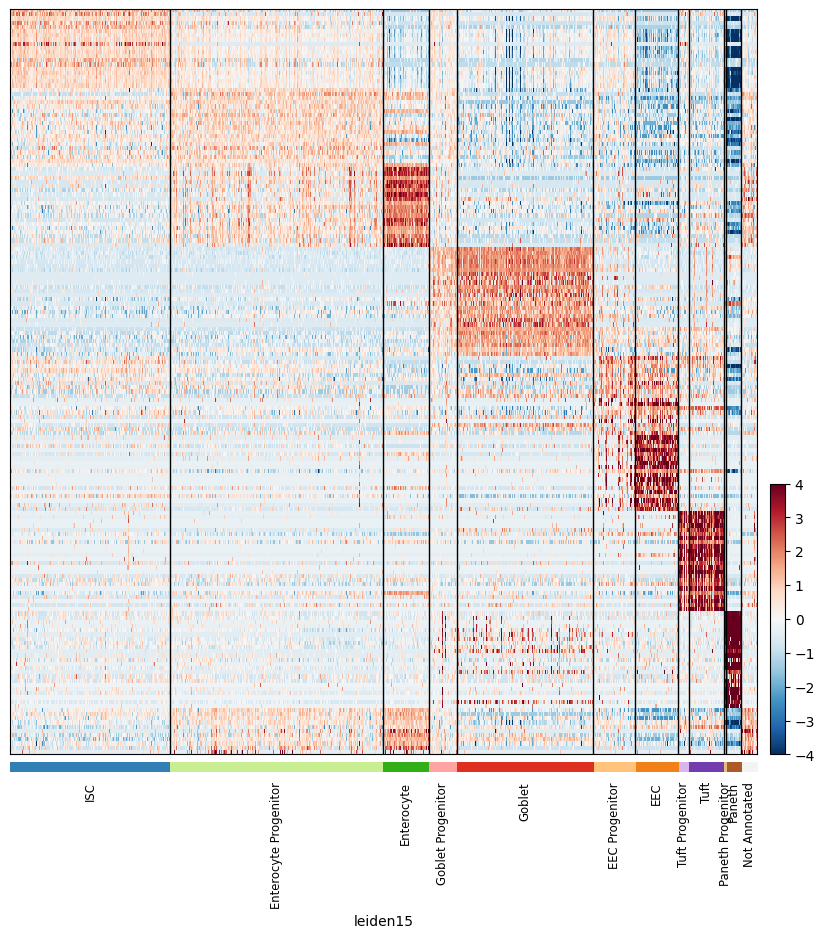

In [222]:
# Plot heatmap using Scanpy
sc.pl.heatmap(adata_marker_scale, var_names=marker_genes, groupby='leiden15', cmap='RdBu_r', swap_axes=True, var_group_labels=None, show_gene_labels=False, figsize=(10,10), dendrogram=False)

### High Fat High Sugar Diet Marker Gene Heatmap

In [223]:
# subset to marker genes and HFD cells
adata_marker = adata_hfd_raw[:, marker_genes].copy()

# compute cell type ratios for plotting
ratios= adata_marker.obs['leiden15'].value_counts()/len(adata_marker.obs['leiden15'])
ratios=ratios/min(ratios)

# scale data for plotting
adata_marker_scale = sc.pp.scale(adata_marker,max_value=4,zero_center=True,copy=True)

/tmp/ipykernel_24573/1303429519.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


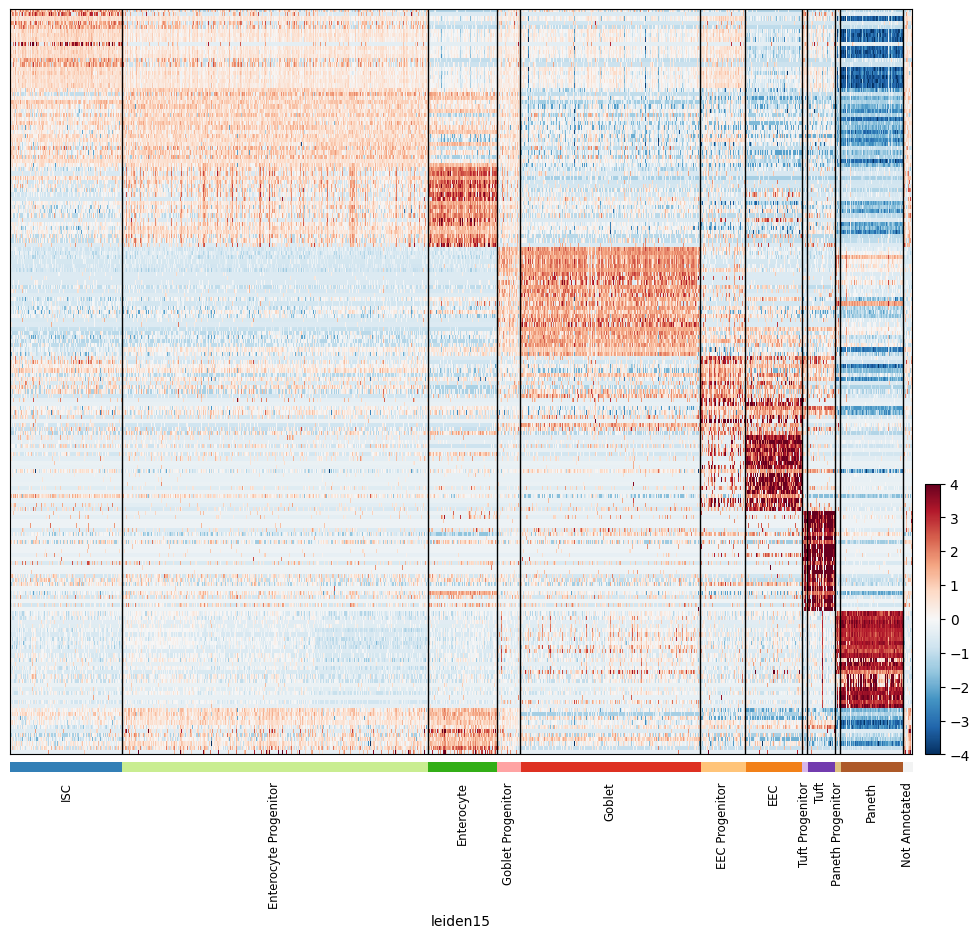

In [233]:
# Plot heatmap using Scanpy
sc.pl.heatmap(adata_marker_scale, 
              var_names=marker_genes, 
              groupby='leiden15', 
              cmap='RdBu_r', 
              swap_axes=True, 
              var_group_labels=None, 
              show_gene_labels=False, 
              figsize=(12,10),  # Increased width to accommodate rotated labels
              dendrogram=False,
              show=False)  # Set show=False to allow further modifications

# Get the current axis
ax = plt.gca()

# Rotate x-axis labels (cell type labels) by 45 degrees and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Adjust the subplot to ensure labels don't get cut off
plt.tight_layout()

# Show the plot
plt.show()

## Miscellaneous Plots

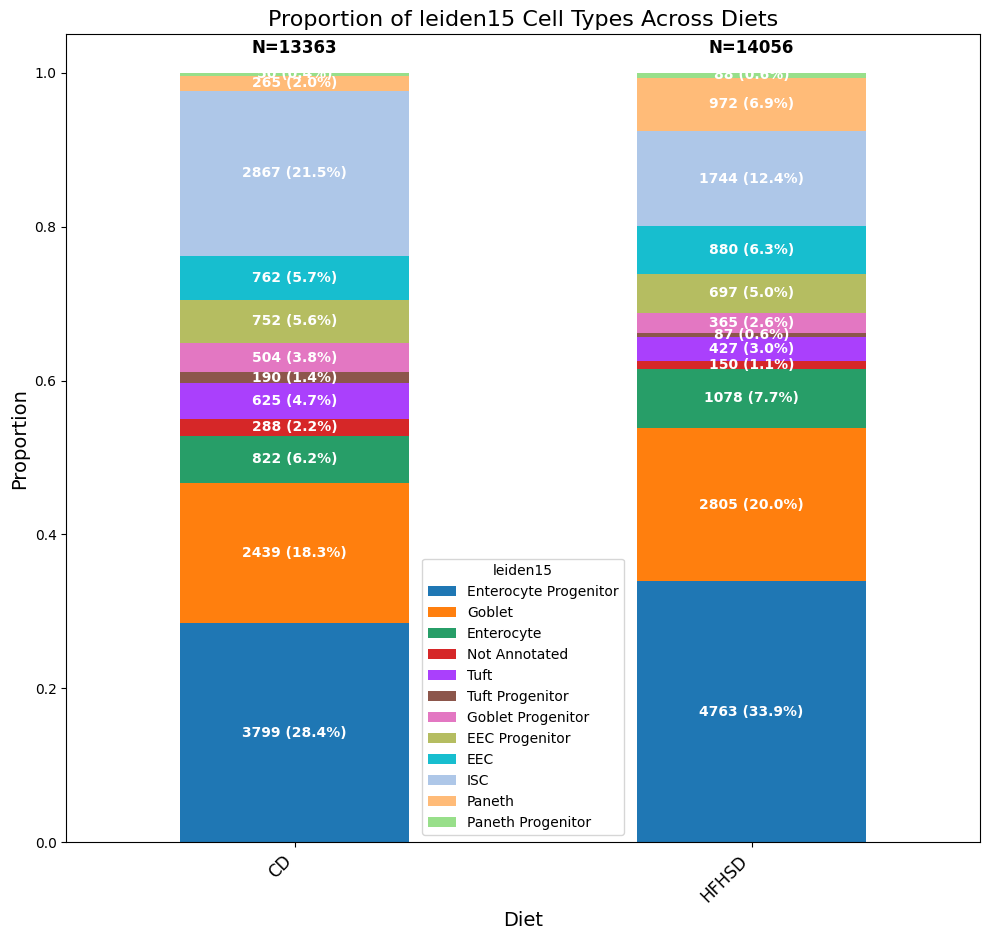

In [34]:
create_stacked_barplot(adata, annotation = 'leiden15')

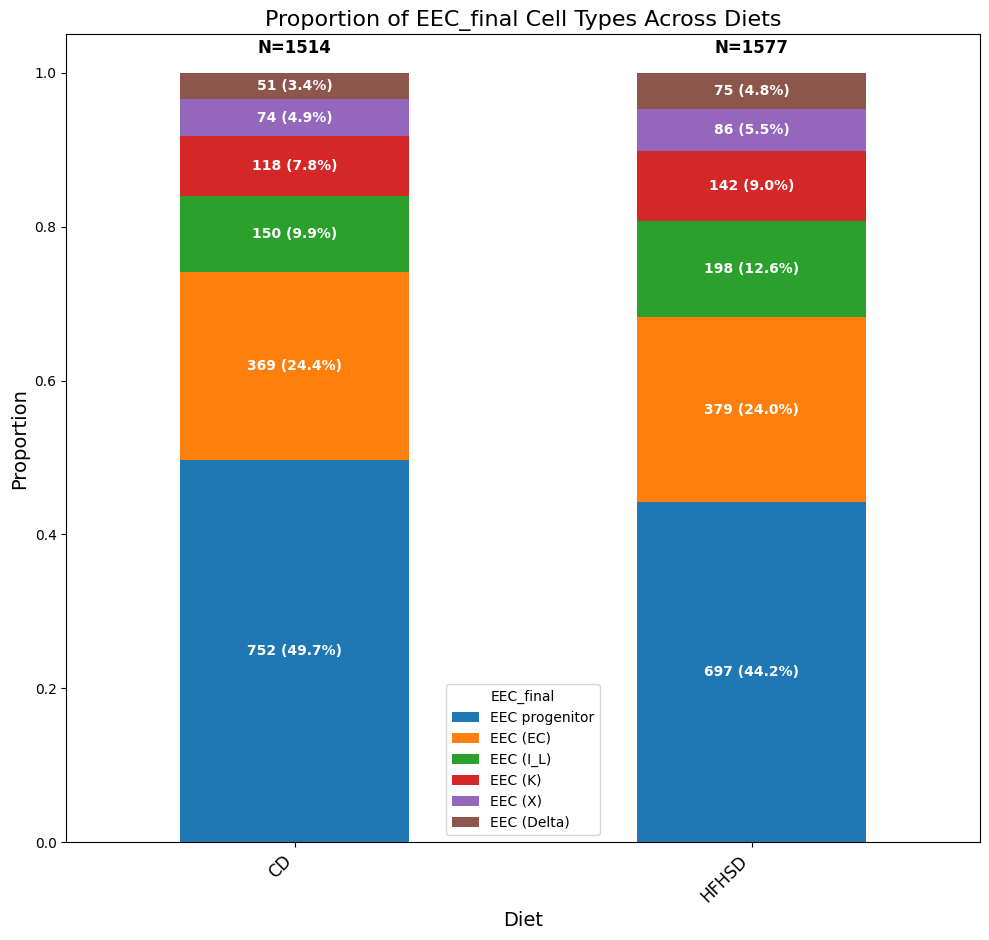

In [35]:
create_stacked_barplot(adata_eec, annotation = 'EEC_final')

## UMAP - diet

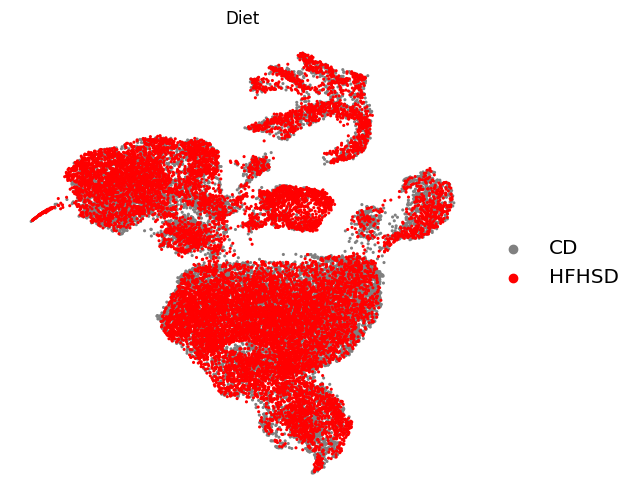

In [14]:
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["Diet"],
    frameon=False,
    size=20,
    legend_fontsize = 'x-large',
    ax=ax
)

# Show the plot
plt.show()

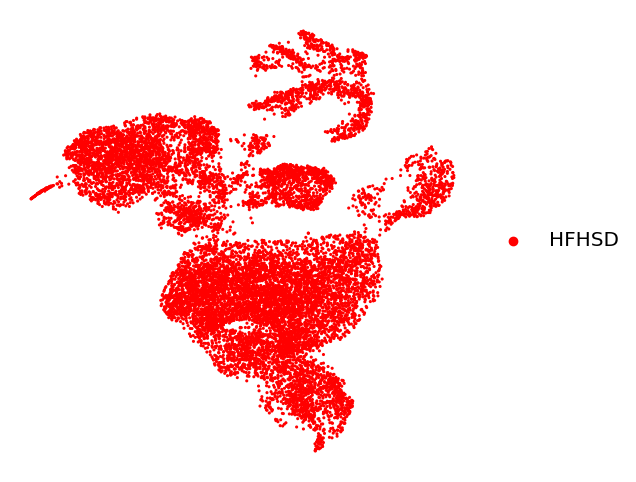

In [17]:
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata[adata.obs['Diet'] == 'HFHSD'],
    color=["Diet"],
    title = '',
    frameon=False,
    size=20,
    legend_fontsize = 'x-large',
    ax=ax
)

# Show the plot
plt.show()

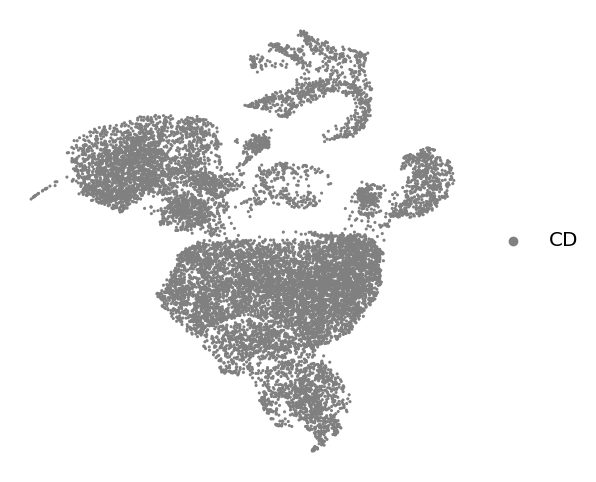

In [18]:
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata[adata.obs['Diet'] == 'CD'],
    color=["Diet"],
    title = '',
    frameon=False,
    size=20,
    legend_fontsize = 'x-large',
    ax=ax
)

# Show the plot
plt.show()